# Trayendo datos de poloniex y convirtiendolos en dataframe

In [6]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2015-05-01 00:00:00"),
                  end=string2ts("2017-09-01 00:00:00"),
                  period=3600*4)
"""
# calculando el retorno del mercado hasta el 4 quitil y del ultimo quintil
df_train = df.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:]
df_test = df.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
"""
per = 0.9
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
cum_return2 = marketReturn(df[int(len(df)*per):]["close"]) 
#cum_return1 = marketReturn(df_train)
#cum_return2 = marketReturn(df_test) 

marketReturn = cum_return1[-1]*100 
marketReturn2 = cum_return2[-1]*100

print "Retorno final del mercado: %s"%(marketReturn)
df.head()

Retorno final del mercado: 204.442508711


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-05-01 03:00:00,0.000034,0.000035,0.000034,0.000034,30025.35629037,1.024092,0.000034
2015-05-01 07:00:00,0.000034,0.000035,0.000034,0.000034,40962.29198805,1.416853,0.000035
2015-05-01 11:00:00,0.000034,0.000035,0.000034,0.000034,54327.64385552,1.864460,0.000034
2015-05-01 15:00:00,0.000035,0.000035,0.000034,0.000034,89306.90296564,3.043450,0.000034
2015-05-01 19:00:00,0.000034,0.000034,0.000034,0.000034,2499.99,0.085249,0.000034


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

Retorno del mercacdo: 204.442508711
Retorno de SMA13 VS EMA5: 632.038680743
Retorno de Precio VS SMA20: 525.768354197
Retorno de Precio VS EMA5: 1851.63751678


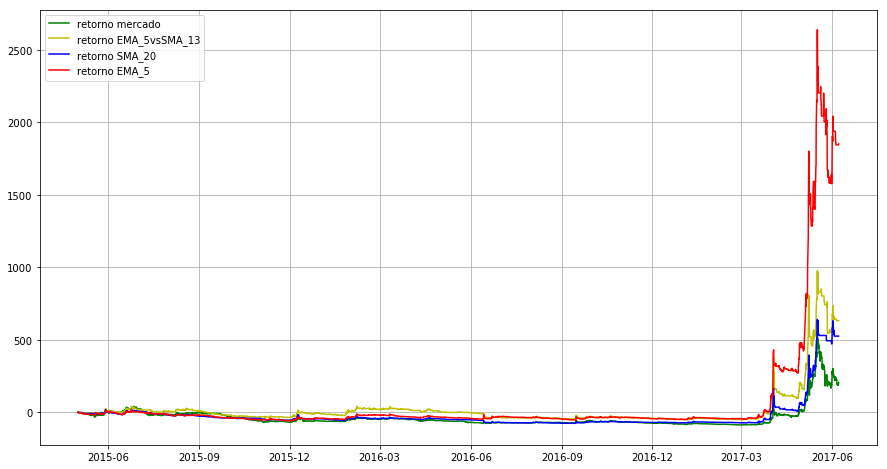

In [7]:
from strategy2 import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
wTrain = w[:int(len(df)*per)]
wTest = w[int(len(df)*per):]
relativeReturn,v = profit(wTrain)
relativeReturnTest,vTest = profit(wTest)

#Precio vs SMA_20
w3 = pricevsSMA(df['weightedAverage'],20)
w3Train = w3[:int(len(df)*per)]
w3Test = w3[int(len(df)*per):]
relativeReturn3,v3 = profit(w3Train)
relativeReturn3Test,v3Test = profit(w3Test)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
w2Train = w2[:int(len(df)*per)]
w2Test = w2[int(len(df)*per):]
relativeReturn2,v2 = profit(w2Train)
relativeReturn2Test,v2Test = profit(w2Test)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)

plt.plot(df.index[:int(len(df)*per)],cum_return1*100,'g', label='retorno mercado')
plt.plot(df.index[:int(len(df)*per)],v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[:int(len(df)*per)],v3*100,'b',label='retorno SMA_20')
plt.plot(df.index[:int(len(df)*per)],v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()


## RSI via stockstacks

In [8]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

Retorno de estrategia ideal: 1.33536023359e+16
4610 513


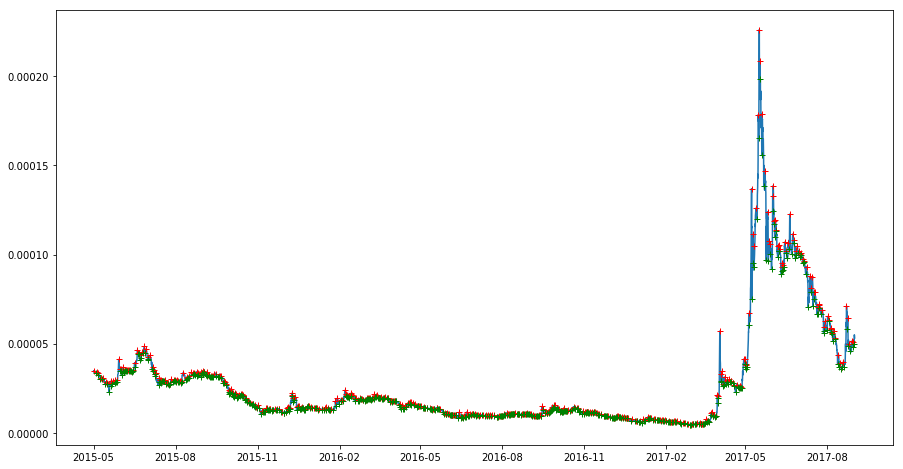

In [9]:
from mldata import ml_data
from orders import orders

df["ml_data"] = ml_data(df["close"])

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],"rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],"wr":stock["wr_14"] ,"sma13ema5":w["w"],"price_sma20":w3["w"],"price_ema5":w2["w"],"ideal_w":w4["w"],"close":df["close"]})

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]
#train = data.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:][1:]
#test = data.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
print len(train),len(test)

# Creando modelo de regresion logistica utilizando sticklearn

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# "price","volumen","rsi","macd","macds","sma13ema5","price_sma20","price_ema5","ideal_w","cci","diff","wr"
features = ["price","rsi","cci"]

# regresion logistica
logreg = LogisticRegression()

# random forests
random_forest = RandomForestClassifier(n_estimators=1000)


# entrenando modelos
logreg.fit(train[features],train["ideal_w"])
random_forest.fit(train[features],train["ideal_w"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

## probando modelo en otros datos

Retorno del mercacdo: -47.796643439
Retorno de SMA13 VS EMA5: 22.9005722869
Retorno de Precio VS SMA20: 18.721723703
Retorno de Precio VS EMA5: 36.0618129855
Retorno de ML_logreg: 31.9365526844
Retorno de ML_randfor: -12.3676973855


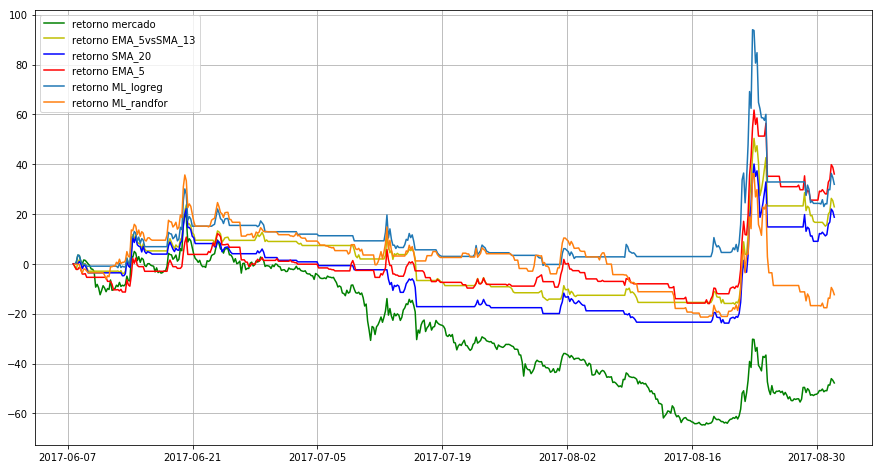

In [21]:
# regresion logistica
w_pred = logreg.predict(test[features])

w5 = pd.DataFrame(data={"w":w_pred,"price":test["close"]})
w5["orders"] = orders(w5["w"])
w5["w"] = w5["w"].shift(1)
relativeReturn5, v5 = profit(w5)

# random forest
w_pred2 = random_forest.predict(test[features])

w6 = pd.DataFrame(data={"w":w_pred2,"price":test["close"]})
w6["orders"] = orders(w6["w"])
w6["w"] = w6["w"].shift(1)
relativeReturn6, v6 = profit(w6)

print 'Retorno del mercacdo: %s'%(marketReturn2)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturnTest*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3Test*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2Test*100)
print 'Retorno de ML_logreg: %s'%(relativeReturn5*100)
print 'Retorno de ML_randfor: %s'%(relativeReturn6*100)

plt.plot(df.index[int(len(data)*per):],cum_return2*100,'g', label='retorno mercado')
plt.plot(df.index[int(len(data)*per):],vTest*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[int(len(data)*per):],v3Test*100,'b',label='retorno SMA_20')
plt.plot(df.index[int(len(data)*per):],v2Test*100,'r',label='retorno EMA_5')
plt.plot(df.index[int(len(data)*per):],v5*100,label='retorno ML_logreg')
plt.plot(df.index[int(len(data)*per):],v6*100,label='retorno ML_randfor')

plt.legend(loc='best')
plt.grid()


In [12]:
from strategy import ml_logreg

# Caracteristicas sobre las que se entrenara el modelo
feature_dic = {"rsi":stock["rsi_14"],"cci":stock["cci"],"price":df["close"]}

# Creando vector de pesos utilizando estrategia de ML de regresión logística
w_logreg = ml_logreg(df["close"],per=0.9,**feature_dic)

# Calculando retorno
relativeReturn6, v6 = profit(w_logreg)

print 'Retorno de ML_strategy: %s'%(relativeReturn6*100)

Retorno de ML_strategy: 31.9365526844


indicators.py:31: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=14).mean()
  roll_up1 = pandas.stats.moments.ewma(up, window_length)
indicators.py:32: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=14).mean()
  roll_down1 = pandas.stats.moments.ewma(down.abs(), window_length)
indicators.py:39: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  roll_up2 = pandas.rolling_mean(up, window_length)
indicators.py:40: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  roll_down2 = pandas.rolling_mean(down.abs(), window_length)
/home/daniel/anacond

5123 5124


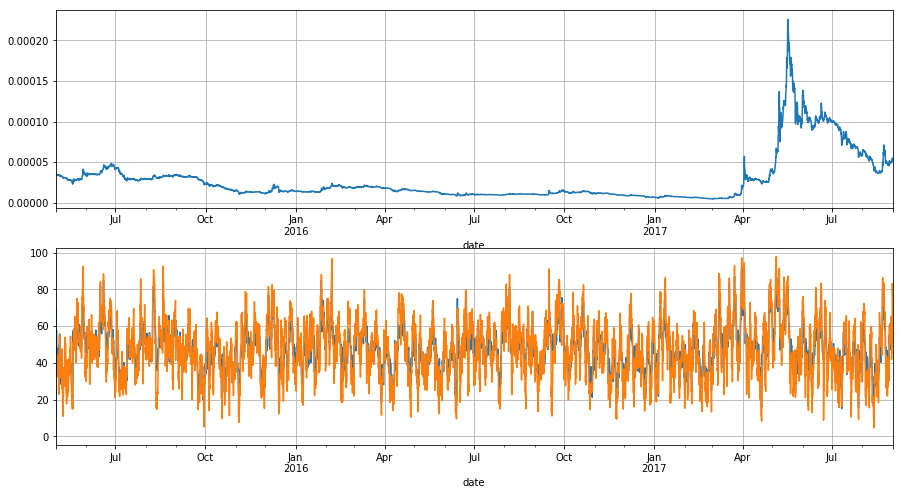

In [13]:
from indicators import rsi

RSI1, RSI2 = rsi(df["close"])

RSI1.head()

plt.subplot(211)
#plt.plot(df.index[1:],df['close'][1:],'r', label='precio')
plt.legend(loc='best')
df["close"].plot()
plt.grid()

plt.subplot(212)
RSI1.plot()
RSI2.plot()
plt.grid()
print len(RSI1),len(df["close"])